In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pystan 

In [2]:
# Reading and handiling the NaN values
df = pd.read_csv('trend2.csv')
df.columns = df.columns.map(str.strip)
df = df.dropna(axis = 0, how = 'any')
df = df.reset_index()
df = df.drop('index',1)
df.sort_values(by=['country'])
df.head()

,country,year,church2,cc,gini_net,rgdpl
0,Australia,1965,26.182790,Australia,29.16514,15.23929
1,Australia,1967,24.744380,Australia,29.50664,16.25018
2,Australia,1979,4.442971,Australia,25.75894,21.58357
3,Australia,1981,27.626460,Australia,28.10000,22.46979
4,Australia,1984,18.099700,Australia,28.80875,23.45019


In [3]:
#Lookup table
df.country = df.country.map(str.strip)
arr_country = df.country.unique()
num_country = len(arr_country)
lookup_country = dict(zip(arr_country, range(num_country)))

In [4]:
#Creating local copies
country = df['country_code'] = df.country.replace(lookup_country).values
religious = df.church2
df['log_religious'] = log_religious = np.log(religious).values
gini_net = df.gini_net.values
rgdpl = df.rgdpl.values

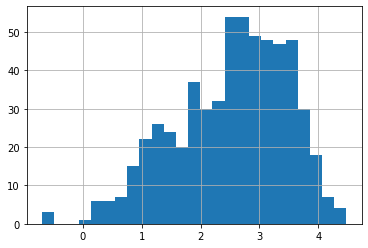

In [5]:
#Distribution of religiosity levels according to countries (log scale):
religious.apply(lambda x: np.log(x)).hist(bins=25)

POOLING APPROACH

In [6]:
#Constructing the data block
pooled_data = """
data {
  int<lower=0> N; 
  vector[N] x;
  vector[N] y;
}
"""
#Initializing parameters
pooled_parameters = """
parameters {
  vector[2] beta;
  real<lower=0> sigma;
} 
"""
#Model
pooled_model = """
model {
  y ~ normal(beta[1] + beta[2] * x, sigma);
}
"""

In [7]:
pooled_data_dict = {'N': len(log_religious),
               'x': gini_net,
               'y': log_religious}

In [8]:
pooled_fit = pystan.stan(model_code=pooled_data + pooled_parameters + pooled_model, data=pooled_data_dict, iter=1000, chains=2)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dd6a876b770652d53bdcc0546345af4b NOW.


In [9]:
pooled_sample = pooled_fit.extract(permuted=True)

In [10]:
b0, m0 = pooled_sample['beta'].T.mean(1)

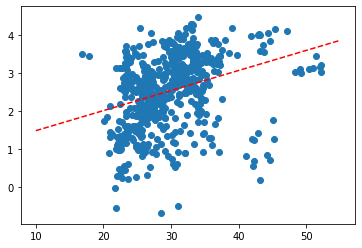

In [11]:
plt.scatter(df.gini_net, np.log(religious))
xvals = np.linspace(10, 55)
plt.plot(xvals, m0*xvals+b0, 'r--')

UNPOOLED MODEL

In [12]:
unpooled_model = """data {
  int<lower=0> N; 
  int<lower=1,upper=37> country[N];
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[37] a;
  real beta;
  real<lower=0,upper=100> sigma;
} 
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] = beta * x[i] + a[country[i]];
}
model {
  y ~ normal(y_hat, sigma);
}"""

In [13]:
unpooled_data = {'N': len(log_religious),
               'country': country+1, # Stan counts starting at 1
               'x': gini_net,
               'y': log_religious}

In [14]:
unpooled_fit = pystan.stan(model_code=unpooled_model, data=unpooled_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3f8c857f8b0dd119801d4a2509241fe7 NOW.


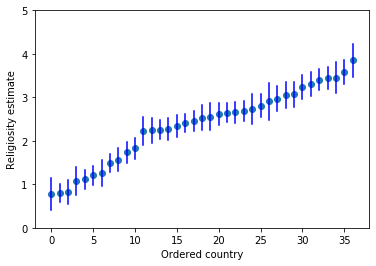

In [15]:
unpooled_estimates = pd.Series(unpooled_fit['a'].mean(0), index=arr_country)
unpooled_se = pd.Series(unpooled_fit['a'].std(0), index=arr_country)

order = unpooled_estimates.sort_values().index

plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)), unpooled_estimates[order], unpooled_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-')
plt.xlim(-2,38); plt.ylim(0,5)
plt.ylabel('Religiosity estimate');plt.xlabel('Ordered country');

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


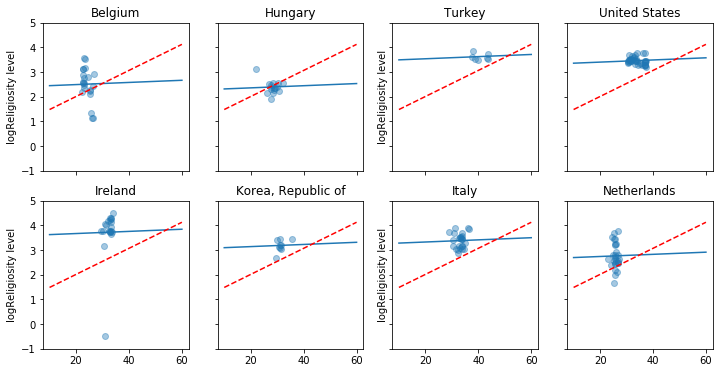

In [16]:
sample_countries = ('Belgium', 'Hungary', 'Turkey','United States', 'Ireland', 'Korea, Republic of', 'Italy', 'Netherlands')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()

m = unpooled_fit['beta'].mean(0)

for i,c in enumerate(sample_countries):
    y = df.log_religious[df.country==c]
    x = df.gini_net[df.country==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    b = unpooled_estimates[c]
    
    # Plot both models and data
    xvals = np.linspace(10,60)
    axes[i].plot(xvals, m*xvals+b)
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    #axes[i].set_xticks([0,1])
    #axes[i].set_xticklabels(['basement', 'giniNet'])
    axes[i].set_ylim(-1, 5)
    #axes[i].set_xlim(10,60)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('logReligiosity level')

PARTIAL POOLING

In [17]:
partial_pooling = """
data {
  int<lower=0> N; 
  int<lower=1,upper=37> country[N];
  vector[N] y;
} 
parameters {
  vector[37] a;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] = a[country[i]];
}
model {
  mu_a ~ normal(0, 1);
  a ~ normal (10 * mu_a, sigma_a);
  y ~ normal(y_hat, sigma_y);
}"""

In [18]:
partial_pool_data = {'N': len(log_religious),
               'country': country+1, # Stan counts starting at 1
               'y': log_religious}

In [19]:
partial_pool_fit = pystan.stan(model_code=partial_pooling, data=partial_pool_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ce5f7bf87bce46f79e80b4acfb1757e8 NOW.


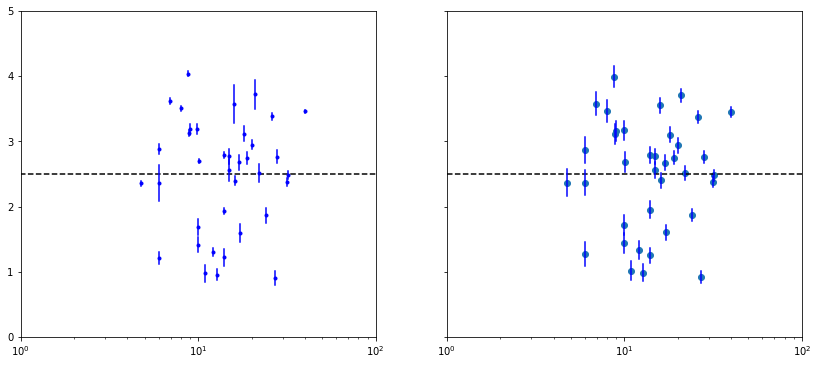

In [20]:
sample_trace = partial_pool_fit['a']

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)
samples, numberOfCountries = sample_trace.shape
jitter = np.random.normal(scale=0.1, size=numberOfCountries)

n_country = df.groupby('country')['year'].count()
unpooled_means = df.groupby('country')['log_religious'].mean()
unpooled_sd = df.groupby('country')['log_religious'].std()
unpooled = pd.DataFrame({'n':n_country, 'm':unpooled_means, 'sd':unpooled_sd})
unpooled['se'] = unpooled.sd/np.sqrt(unpooled.n)

axes[0].plot(unpooled.n + jitter, unpooled.m, 'b.')
for j, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    axes[0].plot([dat.n+j,dat.n+j], [dat.m-dat.se, dat.m+dat.se], 'b-')
axes[0].set_xscale('log')
axes[0].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')

        
samples, numberOfCountries = sample_trace.shape
means = sample_trace.mean(axis=0)
sd = sample_trace.std(axis=0)
axes[1].scatter(n_country.values + jitter, means)
axes[1].set_xscale('log')
axes[1].set_xlim(1,100)
axes[1].set_ylim(0, 5)
axes[1].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')
for j,n,m,s in zip(jitter, n_country.values, means, sd):
    axes[1].plot([n+j]*2, [m-s, m+s], 'b-')

Unpooled and partially pooled difference

VARYING INTERCEPT 

In [21]:
varying_intercept = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> country[N];
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[J] a;
  real b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] = a[country[i]] + x[i] * b;
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ normal (mu_a, sigma_a);
  b ~ normal (0, 1);
  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

In [22]:
varying_intercept_data = {'N': len(log_religious),
                          'J': num_country,
                          'country': country+1, 
                          'x': gini_net,
                          'y': log_religious}

In [23]:
varying_intercept_fit = pystan.stan(model_code=varying_intercept, data=varying_intercept_data, iter=1000, chains=2)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_be2696cd99a7d036b4929d82381f1d35 NOW.


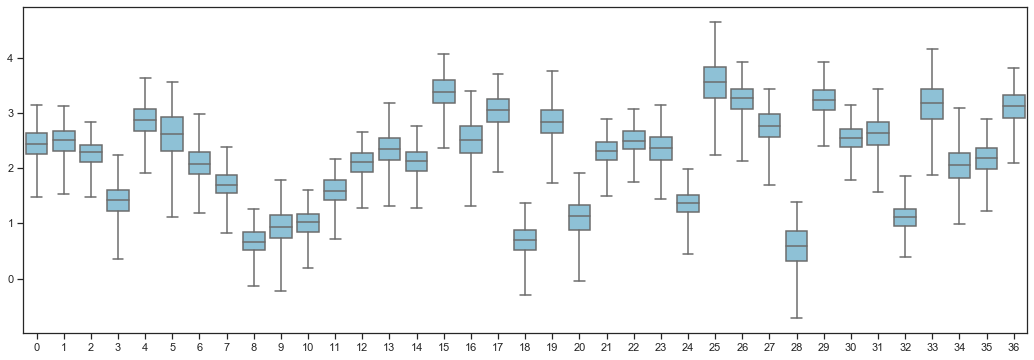

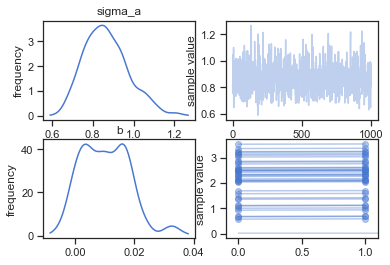

In [24]:
a_sample = pd.DataFrame(varying_intercept_fit['a'])

sns.set(style="ticks", palette="muted", color_codes=True)

# Plot the orbital period with horizontal boxes
plt.figure(figsize=(18, 6))
sns.boxplot(data=a_sample, whis=np.inf, color="c")

varying_intercept_fit.plot(pars=['sigma_a', 'b']);

varying_intercept_fit['b'].mean()

xvals = np.arange(2)

bp = varying_intercept_fit['a'].mean(axis=0)
mp = varying_intercept_fit['b'].mean()

for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,1.1);

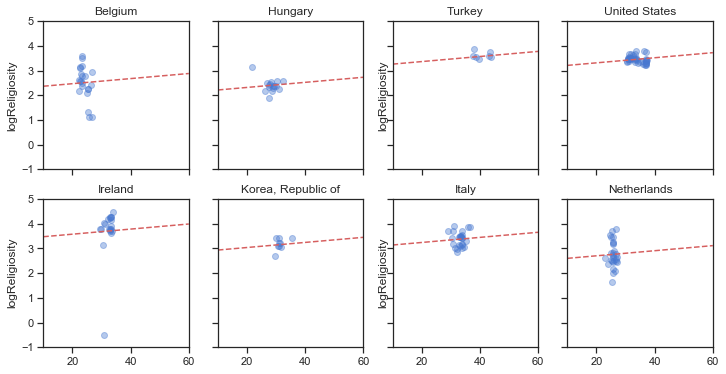

In [25]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
for i,c in enumerate(sample_countries):

    # Plot country data
    y = df.log_religious[df.country==c]
    x = df.gini_net[df.country==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    xvals = np.linspace(10, 60)
    
    # Partial pooling estimate
    axes[i].plot(xvals, mp*xvals+bp[lookup_country[c]], 'r--')
    axes[i].set_ylim(-1, 5)
    axes[i].set_xlim(10,60)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('logReligiosity')

VARYING INTERCEPT WITH DIFFERENT B PRIOR 

In [26]:
varying_intercept = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> country[N];
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[J] a;
  real b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] = a[country[i]] + x[i] * b;
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ normal (mu_a, sigma_a);
  b ~ normal (0.04, 0.02);
  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

In [27]:
varying_intercept_data = {'N': len(log_religious),
                          'J': num_country,
                          'country': country+1, 
                          'x': gini_net,
                          'y': log_religious}

In [28]:
varying_intercept_fit = pystan.stan(model_code=varying_intercept, data=varying_intercept_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_49480eb5063a7a8e75446f0667448555 NOW.


0.013650929436434197

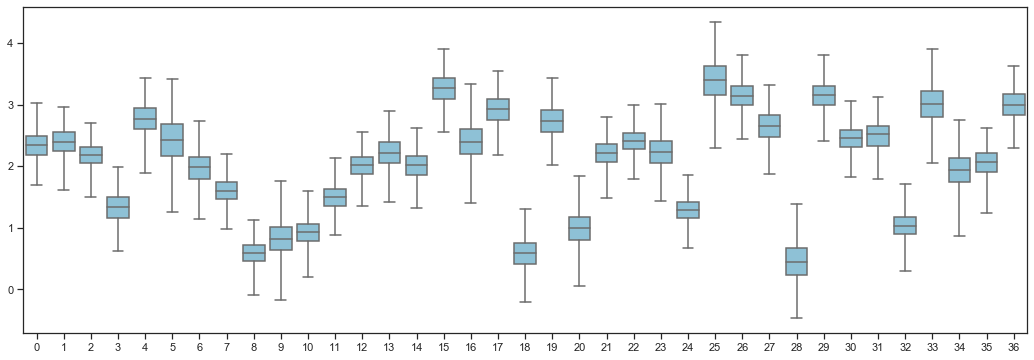

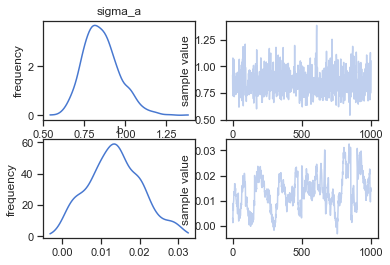

In [29]:
a_sample = pd.DataFrame(varying_intercept_fit['a'])


sns.set(style="ticks", palette="muted", color_codes=True)

# Plot the orbital period with horizontal boxes
plt.figure(figsize=(18, 6))
sns.boxplot(data=a_sample, whis=np.inf, color="c")

varying_intercept_fit.plot(pars=['sigma_a', 'b']);

varying_intercept_fit['b'].mean()

If the prior is uninformative the data leads the outcomes. When the prior is informative the outcome is leaded by both the data and the prior. If the prior is more informative, the more data should be gathered or the set should be changed. However, the data is big and reliable enough it will dominate the beta prior. 

HIERARCHICAL INTERCEPT

In [30]:
hierarchical_intercept = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> country[N];
  vector[N] u;
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[J] a;
  vector[2] b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  vector[N] m;
  for (i in 1:N) {
    m[i] = a[country[i]] + u[i] * b[1];
    y_hat[i] = m[i] + x[i] * b[2];
  }
}
model {
  mu_a ~ normal(0, 1);
  a ~ normal(mu_a, sigma_a);
  b ~ normal(0, 1);
  y ~ normal(y_hat, sigma_y);
}
"""

In [31]:
hierarchical_intercept_data = {'N': len(log_religious),
                          'J': len(n_country),
                          'country': country+1, # Stan counts starting at 1
                          'u': rgdpl,
                          'x': gini_net,
                          'y': log_religious}

In [32]:
hierarchical_intercept_fit = pystan.stan(model_code=hierarchical_intercept, data=hierarchical_intercept_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_96d87bbff00054f025a592520fc972e3 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


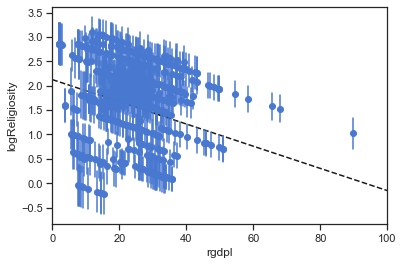

In [33]:
m_means = hierarchical_intercept_fit['m'].mean(axis=0)
plt.scatter(rgdpl, m_means)
g0 = hierarchical_intercept_fit['mu_a'].mean()
g1 = hierarchical_intercept_fit['b'][:, 0].mean()
xvals = np.linspace(0, 100)
plt.plot(xvals, g0+g1*xvals, 'k--')
plt.xlim(0,100)

m_se = hierarchical_intercept_fit['m'].std(axis=0)
for ui, m, se in zip(rgdpl, m_means, m_se):
    plt.plot([ui,ui], [m-se, m+se], 'b-')
plt.xlabel('rgdpl'); plt.ylabel('logReligiosity')

xbar = df.groupby('country')['gini_net'].mean().rename(lookup_country).values

x_mean = xbar[country]

CONTROL VARIABLE HAS A SIGNIFICANT EFFECT IN RELIGIOSITY SO; VARYING INTERCEPT WITH RGDPL

In [34]:
varying_intercept = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> country[N];
  vector[N] x1;
  vector[N] x2;
  vector[N] y;
} 
parameters {
  vector[J] a;
  real b1;
  real b2;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] = a[country[i]] + x1[i] * b1 + x2[i] * b2;
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ normal (mu_a, sigma_a);
  b1 ~ normal (0, 1);
  b2 ~ normal (0, 1);
  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

In [35]:
varying_intercept_data = {'N': len(log_religious),
                          'J': num_country,
                          'country': country+1, # Stan counts starting at 1
                          'x1': gini_net,
                          'x2': rgdpl,
                          'y': log_religious}

In [36]:
varying_intercept_fit = pystan.stan(model_code=varying_intercept, data=varying_intercept_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8fcb7117693b818b93253442e8420d1f NOW.


-0.022961551737737614

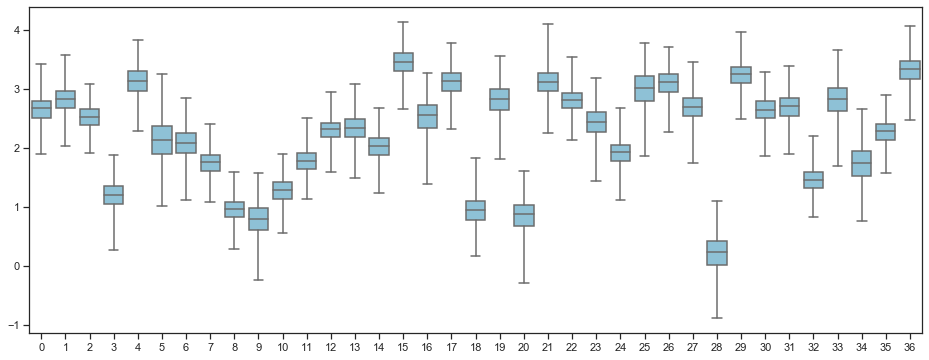

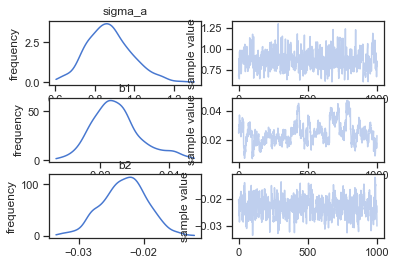

In [37]:
a_sample = pd.DataFrame(varying_intercept_fit['a'])

sns.set(style="ticks", palette="muted", color_codes=True)
# Plot the orbital period with horizontal boxes
plt.figure(figsize=(16, 6))
sns.boxplot(data=a_sample, whis=np.inf, color="c")

varying_intercept_fit.plot(pars=['sigma_a', 'b1','b2']);

varying_intercept_fit['b1'].mean()
varying_intercept_fit['b2'].mean()
